In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


#Be sure to turn on GPU and set Internet to "Internet connected"


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../working"))

# Any results you write to the current directory are saved as output.

['__output__.json', '__notebook__.ipynb']


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from glob import glob
from sklearn.model_selection import train_test_split

daisy_train = glob('../input/flowers/flowers/Train/daisy/*.jpg')
dandelion_train = glob('../input/flowers/flowers/Train/dandelion/*.jpg')
rose_train = glob('../input/flowers/flowers/Train/rose/*.jpg')
sunflower_train = glob('../input/flowers/flowers/Train/sunflower/*.jpg')
tulip_train = glob('../input/flowers/flowers/Train/tulip/*.jpg')

print('daisy_train',len(daisy_train))
print('dandelion_train',len(dandelion_train))
print('rose_train',len(rose_train))
print('sunflower_train',len(sunflower_train))
print('tulip_train',len(tulip_train))

TRAIN_DIR = '../input/flowers/flowers/Train/'
TEST_DIR = '../input/flowers/flowers/Test'
VALID_DIR = '../input/flowers/flowers/Valid'


daisy_train 617
dandelion_train 842
rose_train 628
sunflower_train 590
tulip_train 788


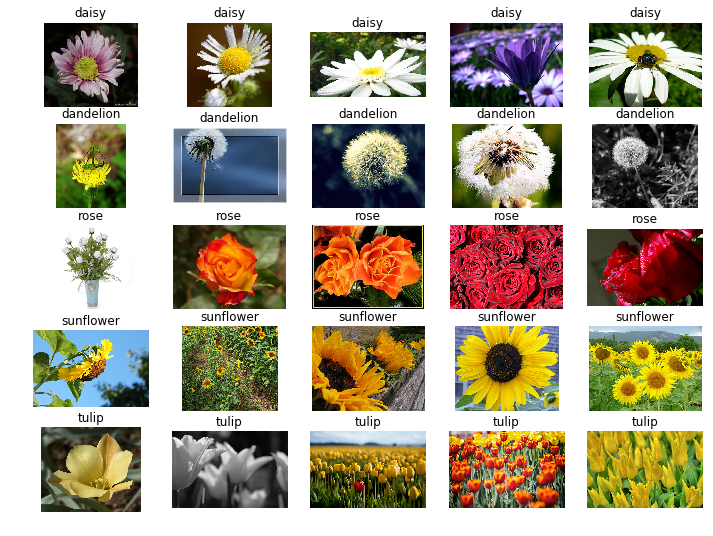

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

daisy = np.random.choice(daisy_train, 5)
dandelion = np.random.choice(dandelion_train, 5)
rose = np.random.choice(rose_train, 5)
sunflower = np.random.choice(sunflower_train, 5)
tulip = np.random.choice(tulip_train, 5)
data = np.concatenate((daisy,dandelion,rose,sunflower,tulip))
labels = 5 * ['daisy'] + 5 * ['dandelion'] + 5 * ['rose'] + 5 * ['sunflower'] + 5 * ['tulip'] 

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

In [5]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
#from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception,preprocess_input

CLASSES = 5
    
# setup model
#base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = Xception(include_top=False, weights='imagenet')
#base_model = VGG19(weights='imagenet', include_top=False)

# Add more layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D(name='avg_pool'))

#add more layers here if needed

#model.add(Dense(200))
#model.add(Dropout(0.4))
#model.add(Dense(200))
#model.add(Dropout(0.4))


#best
#model.add(Dense(64))
#model.add(Dropout(0.4))


model.add(Dense(32))
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Dropout(0.4))


model.add(Dense(CLASSES, activation='softmax'))
#model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning - set all layers of the base model to frozen
for layer in base_model.layers:
   layer.trainable = False
      
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Using TensorFlow backend.


83689472/83683744 [==============================] - 6s 0us/step


In [6]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [7]:
#for layer in base_model.layers:
#    layer.trainable = False

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, None, None, 2048)  20861480  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                65568     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

In [9]:
Unfreeze the last x layers from bottom
x = 6
for layer in base_model.layers[-x:]:
     layer.trainable = True
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



SyntaxError: invalid syntax (<ipython-input-9-9c8e0f97e8a7>, line 1)

In [10]:
for layer in base_model.layers:
    if layer.trainable == True:
        print(layer.name)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 128

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=100,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=107,
    class_mode='categorical')

Found 3465 images belonging to 5 classes.
Found 429 images belonging to 5 classes.


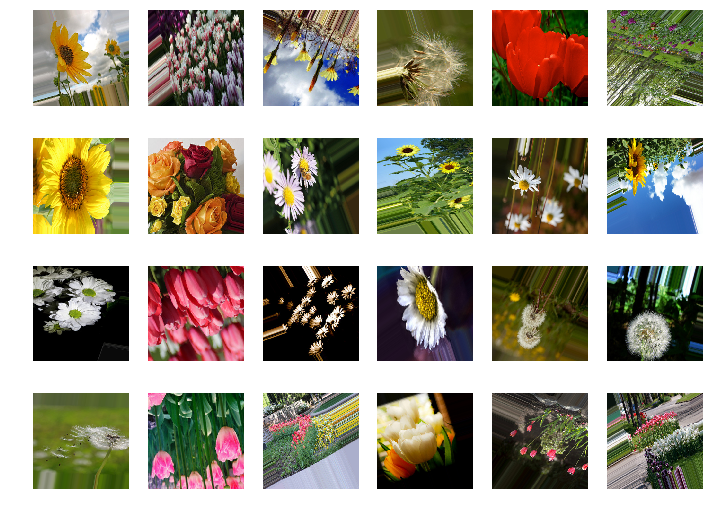

In [12]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch[0:24], y_batch[0:24])):
    plt.subplot(4, 6, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [13]:
from keras.callbacks import ModelCheckpoint
EPOCHS = 25
STEPS_PER_EPOCH = 4
VALIDATION_STEPS = 4

checkpointer = ModelCheckpoint(filepath='weights_{epoch:02d}_{val_loss:.4f}_hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpointer])


Epoch 1/25
4/4 [==============================] - 37s 9s/step - loss: 1.7041 - acc: 0.2625 - val_loss: 1.3364 - val_acc: 0.4790

Epoch 00001: val_loss improved from inf to 1.33637, saving model to weights_01_1.3364_hdf5
Epoch 2/25
4/4 [==============================] - 15s 4s/step - loss: 1.4784 - acc: 0.3450 - val_loss: 1.1313 - val_acc: 0.5870

Epoch 00002: val_loss improved from 1.33637 to 1.13133, saving model to weights_02_1.1313_hdf5
Epoch 3/25
4/4 [==============================] - 14s 4s/step - loss: 1.3352 - acc: 0.4600 - val_loss: 0.9881 - val_acc: 0.6957

Epoch 00003: val_loss improved from 1.13133 to 0.98810, saving model to weights_03_0.9881_hdf5
Epoch 4/25
4/4 [==============================] - 15s 4s/step - loss: 1.1878 - acc: 0.5325 - val_loss: 0.8672 - val_acc: 0.7205

Epoch 00004: val_loss improved from 0.98810 to 0.86725, saving model to weights_04_0.8672_hdf5
Epoch 5/25
4/4 [==============================] - 14s 4s/step - loss: 1.1122 - acc: 0.5350 - val_loss: 0.843

In [14]:
#model.load_weights('weights_09_0.3497_hdf5')

In [15]:
# code to clean up the working directory in case you fill it with checkpoints
###WARNING####. this will delete all checkpoints, adjust as needed
#import os
#files = os.listdir('../working')
#for file in files:
#    if file.endswith("f5"):
#        os.remove(os.path.join('../working',file))

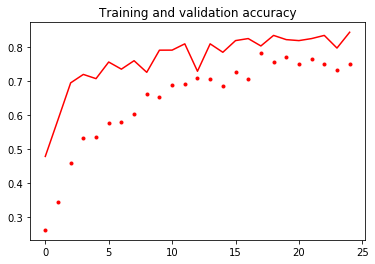

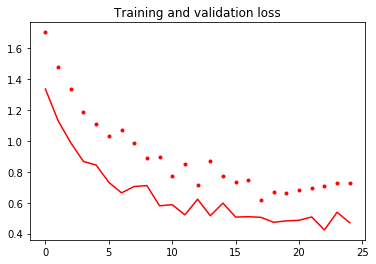

In [16]:
#plot the training history

def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

In [17]:
#Create a single test set from all of the test directories
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model
from tqdm import tqdm
import cv2

X = []
X_p = []
Y = []
files = []
image_name = []
def make_train_data(DIR,label):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        if path.endswith('.jpg'):
            img = image.load_img(path, target_size=(HEIGHT, WIDTH))
            img_p = Image.open(path).convert('RGB')
            x = image.img_to_array(img)
            #x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            X.append(np.array(x))
            Y.append(label)
            X_p.append(np.array(img_p))
            files.append(path)
            image_name.append(path.split('/')[-1])
make_train_data('../input/flowers/flowers/Test/daisy/',0)
make_train_data('../input/flowers/flowers/Test/dandelion/',1)
make_train_data('../input/flowers/flowers/Test/rose/',2)
make_train_data('../input/flowers/flowers/Test/sunflower/',3)
make_train_data('../input/flowers/flowers/Test/tulip/',4)
print(len(X))
X=np.array(X)
X_p=np.array(X_p)

100%|██████████| 98/98 [00:00<00:00, 119.05it/s]


429


In [18]:
import numpy as np
from sklearn.metrics import accuracy_score

predicts = model.predict(X)
predicts = np.argmax(predicts, axis=1)

accuracy_score(Y, predicts)

0.7972027972027972

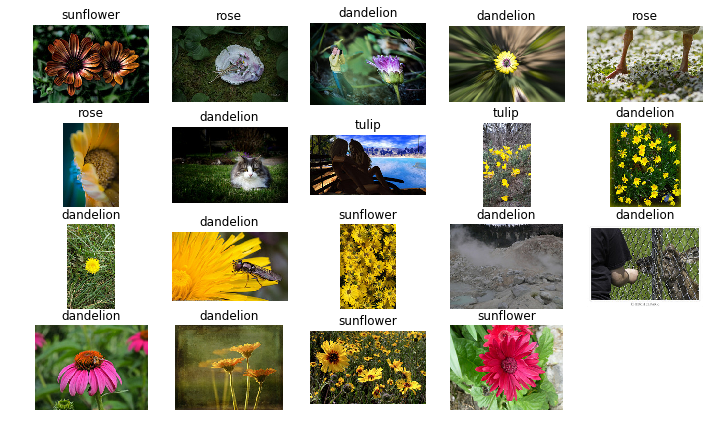

In [19]:
#show first 25 misclassified Daisies
labels = ("daisy","dandelion","rose","sunflower","tulip")

N, R, C = 25, 5, 5
count = 0
plt.figure(figsize=(12, 9))
for k in range(len(predicts)):
    if count<25:
        if (Y[k] == 0) & (predicts[k] != 0):
            im = Image.open(files[k]).convert('RGB')
            plt.subplot(R, C, count+1)
            plt.title(labels[predicts[k]])
            plt.imshow(np.asarray(im))
            plt.axis('off')
            count = count + 1
    

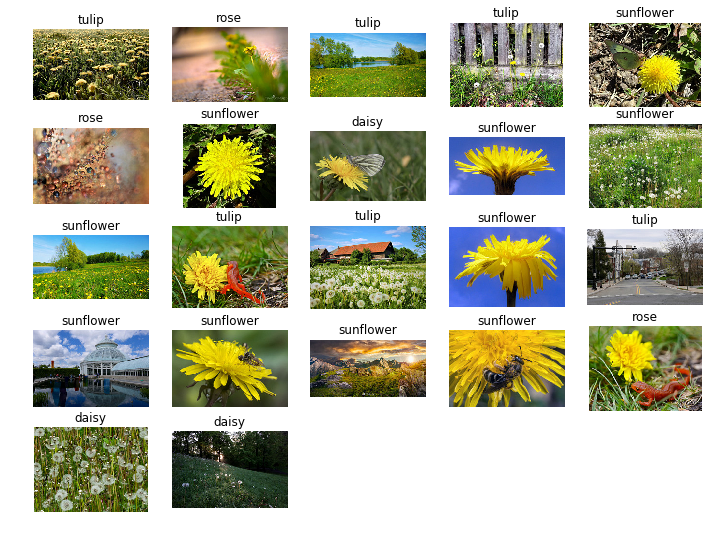

In [20]:
#misclassified Dandelion
N, R, C = 25, 5, 5
count = 0
plt.figure(figsize=(12, 9))
for k in range(len(predicts)):
    if count<25:
        if (Y[k] == 1) & (predicts[k] != 1):
            im = Image.open(files[k]).convert('RGB')
            plt.subplot(R, C, count+1)
            plt.title(labels[predicts[k]])
            plt.imshow(np.asarray(im))
            plt.axis('off')
            count = count + 1
    

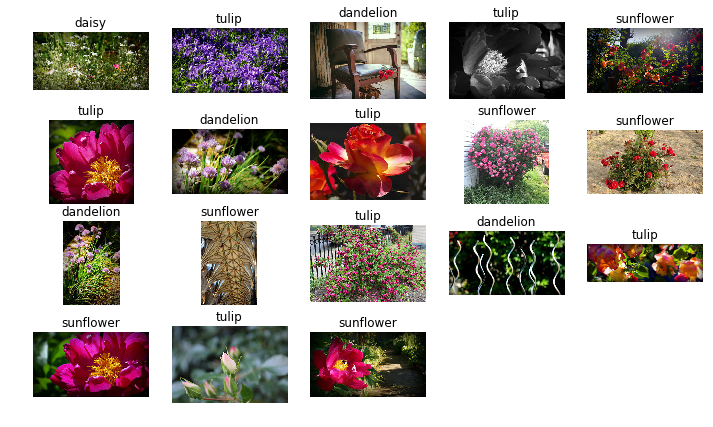

In [21]:
#misclassified Roses
N, R, C = 25, 5, 5
count = 0
plt.figure(figsize=(12, 9))
for k in range(len(predicts)):
    if count<25:
        if (Y[k] == 2) & (predicts[k] != 2):
            im = Image.open(files[k]).convert('RGB')
            plt.subplot(R, C, count+1)
            plt.title(labels[predicts[k]])
            plt.imshow(np.asarray(im))
            plt.axis('off')
            count = count + 1

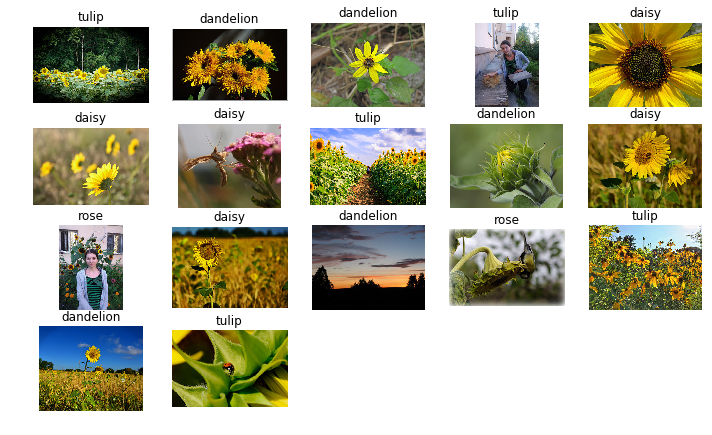

In [22]:
#misclassified Sunflowers
N, R, C = 25, 5, 5
count = 0
plt.figure(figsize=(12, 9))
for k in range(len(predicts)):
    if count<25:
        if (Y[k] == 3) & (predicts[k] != 3):
            im = Image.open(files[k]).convert('RGB')
            plt.subplot(R, C, count+1)
            plt.title(labels[predicts[k]])
            plt.imshow(np.asarray(im))
            plt.axis('off')
            count = count + 1

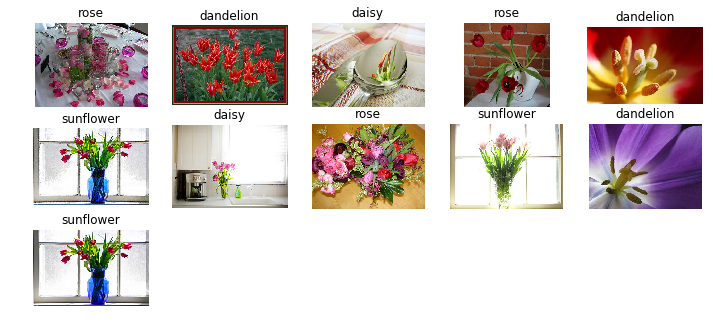

In [23]:
#misclassified Tulips
N, R, C = 25, 5, 5
count = 0
plt.figure(figsize=(12, 9))
for k in range(len(predicts)):
    if count<25:
        if (Y[k] == 4) & (predicts[k] != 4):
            im = Image.open(files[k]).convert('RGB')
            plt.subplot(R, C, count+1)
            plt.title(labels[predicts[k]])
            plt.imshow(np.asarray(im))
            plt.axis('off')
            count = count + 1

In [24]:
#Function for plotting confusion matrix

import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[57 10  3  4  2]
 [ 3 83  3 10  6]
 [ 1  4 60  6  7]
 [ 5  5  2 55  5]
 [ 2  3  3  3 87]]


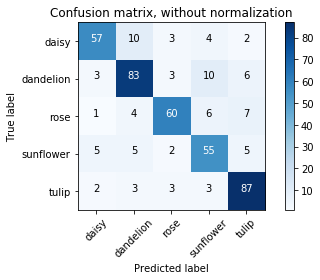

In [25]:
#Plot confusion matrix
cnf_matrix = confusion_matrix(Y, predicts)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')

plt.show()

In [26]:

for i in range(len(Y)):
    if (predicts[i] == 2) & (Y[i] == 2):
        print(i)

181
182
183
185
186
187
188
191
192
193
195
196
198
199
201
203
205
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
224
225
226
227
228
229
230
231
232
234
236
237
238
239
241
242
243
244
245
246
247
248
250
251
252
255
256
258


In [27]:
#a few functions to create a single image view

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds,Y):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("daisy","dandelion","rose","sunflower","tulip")
    preds_pos = np.arange(len(labels))
    preds_label = labels[Y]
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh(preds_pos, preds, alpha=0.5)
    plt.yticks(preds_pos, labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()
    return preds_label

'rose'

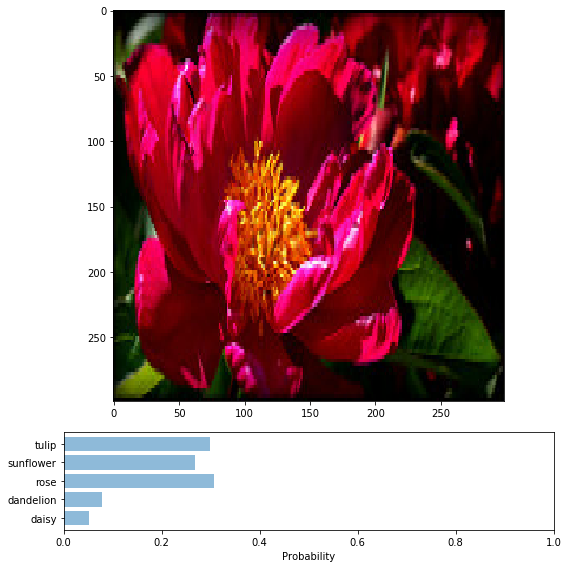

In [28]:
img_num = 248
img = image.load_img(files[img_num], target_size=(HEIGHT, WIDTH))
preds = predict(model, img)
preds_label = plot_preds(np.asarray(img), preds,Y[img_num])
preds_label

In [29]:
#creates a list of numbers from 0 to length of images for the ImageID field
list_of_num = [i for i in range(0,len(predicts))]

#Creates a dataframe that can be saved as a csv for submission
submission_data = pd.DataFrame(
    {'ImageId': image_name,
     'Label': predicts
    })

In [30]:
# code to allow you to download submission csv with commiting
# https://www.kaggle.com/rtatman/download-a-csv-file-from-a-kernel
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(submission_data)
